<a href="https://colab.research.google.com/github/Aquib88raza/image-classification-ANKLE/blob/main/Knn%2BINCE97new86_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Total number of images: 144
Number of images in the training set: 115
Number of images in the testing set: 29

Train file names:
['CCH-059-7-ankle-SL1.jpg' 'CCH-N-043-8-ankle-SR1.jpg'
 'CCH-N-057-8-ankle-SR1.jpg' 'CCH-N-044-8- ankle-SR3.jpg'
 'CCH-N-029-8-ankle-FR1.jpg' 'CCH-N-026-8-ankle-FL3.jpg'
 'CCH-N-036-8-ankle-SR2.jpg' 'CCH-P-035-8-ankle-SL2.jpg'
 'CCH-N-065-7-ankle-FL1.jpg' 'CCH-L-032-8-ankle-FR1.jpg'
 'CCH-E-019-8-ankle-SR3.jpg' 'CCH-N-048-8-ankle-SL1.jpg'
 'CCH-N-009-8-ankle FL1.jpg' 'CCH-N-018-8-ankle-SR2.jpg'
 'CCH-N-056-8-ankle-SL.jpg' 'CCH-N-037-8-ankle-SR2.jpg'
 'CCH-N-063-7-ankle-FL1.jpg' 'CCH-M-049-8-ankle-SR1.jpg'
 'CCH-N-034-8-ankle-FR1.jpg' 'CCH-N-034-8-ankle-SR4.jpg'
 'CCH-N-033-8-ankle-SL2.jpg' 'CCH-L-048-8-ankle-SR2.jpg'
 'CCH-059-7-ankle-FR2.jpg' 'CCH-N-066-7- ankle-FL1.jpg'
 'CCH-N-027-8-ankle-SR3.jpg' 'CCH-N-048-8-ankle-FL1.jpg'
 'CCH-N-063-7-ankle-FR1.jpg' 'CCH-N-033-8-ankle-FL3.jpg'
 'CCH-B-073-2-ankle-FR1.jpg' 'CCH-N-006-8-ankle-SL2.jpg'
 'CCH-N-052-8-ankle

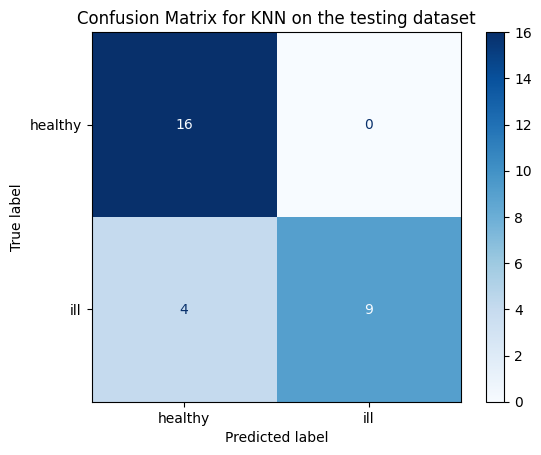

Classification Report for KNN on the training dataset:
               precision    recall  f1-score   support

           0       0.83      0.98      0.90        56
           1       0.98      0.81      0.89        59

    accuracy                           0.90       115
   macro avg       0.91      0.90      0.90       115
weighted avg       0.91      0.90      0.90       115



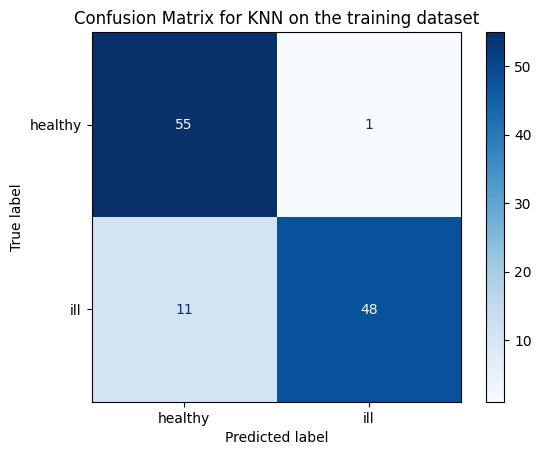

In [10]:
import os
import numpy as np
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to your image directories for healthy and ill samples
normal_path = "/content/drive/MyDrive/Ankle_balance/normal"
ill_path = "/content/drive/MyDrive/Ankle_balance/ill"

# Create lists to store image data and labels
dataset_images = []
dataset_labels = []
dataset_file_names = []
# Reading images from the normal directory
for files in os.listdir(normal_path):
    if files.endswith(".jpg"):
        file_path = os.path.join(normal_path, files)
        image = cv2.imread(file_path)
        if image is not None and not image.size == 0:
            size = (256, 256)  # Define the size for resizing images (InceptionV3 input size)
            image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
            dataset_images.append(image)
            dataset_labels.append(0)  # Label for healthy images
            dataset_file_names.append(files)
# Reading images from the ill directory
for files in os.listdir(ill_path):
    if files.endswith(".jpg"):
        file_path = os.path.join(ill_path, files)
        image = cv2.imread(file_path)
        if image is not None and not image.size == 0:
            size = (256, 256)  # Define the size for resizing images (InceptionV3 input size)
            image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
            dataset_images.append(image)
            dataset_labels.append(1)  # Label for ill images
            dataset_file_names.append(files)
# Convert the lists to NumPy arrays
dataset_images = np.array(dataset_images)
dataset_labels = np.array(dataset_labels)
dataset_file_names = np.array(dataset_file_names)
# Normalize pixel values to the range [0, 1]
dataset_images = dataset_images / 255.0

seed = 42  # You can use any integer value as the seed
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test, train_file_names, test_file_names = train_test_split(dataset_images, dataset_labels, dataset_file_names, test_size=0.2, random_state=seed)
# Calculate the total number of images
total_images = len(dataset_images)
print("Total number of images:", total_images)
# Split the dataset into training and testing sets

# Calculate the number of images in the training set
num_train_images = len(X_train)
print("Number of images in the training set:", num_train_images)

# Calculate the number of images in the testing set
num_test_images = len(X_test)
print("Number of images in the testing set:", num_test_images)

# Print the names of each test and train data
print("\nTrain file names:")
print(train_file_names)

print("\nTest file names:")
print(test_file_names)
# Create an InceptionV3 model for feature extraction
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the InceptionV3-based model on the training dataset
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Extract features from the InceptionV3-based model for both training and testing datasets
X_train_features = model.predict(X_train)
X_test_features = model.predict(X_test)

# Apply Principal Component Analysis (PCA) to reduce dimensionality
n_components = min(X_train_features.shape[0], X_train_features.shape[1])  # Set it to the minimum
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_features)
X_test_pca = pca.transform(X_test_features)

# Create the KNN classifier
knn_classifier = KNeighborsClassifier()

# Define a range of hyperparameters to search over for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11,],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Algorithm used to compute the nearest neighbors
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data with PCA features
grid_search.fit(X_train_pca, y_train)

# Get the best parameters and best accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

# Predict on the testing dataset using the best KNN classifier with PCA features
best_knn_classifier = grid_search.best_estimator_
y_test_pred = best_knn_classifier.predict(X_test_pca)

# Generate classification report for the testing dataset
test_report = classification_report(y_test, y_test_pred)
print("Classification Report for KNN on the testing dataset:\n", test_report)

# Calculate the confusion matrix for the testing dataset
test_cm = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix for the testing dataset
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=["healthy", "ill"])
test_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for KNN on the testing dataset")
plt.show()

# Predict on the training dataset using the best KNN classifier with PCA features
y_train_pred = best_knn_classifier.predict(X_train_pca)

# Generate classification report for the training dataset
train_report = classification_report(y_train, y_train_pred)
print("Classification Report for KNN on the training dataset:\n", train_report)

# Calculate the confusion matrix for the training dataset
train_cm = confusion_matrix(y_train, y_train_pred)

# Display the confusion matrix for the training dataset
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=["healthy", "ill"])
train_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for KNN on the training dataset")
plt.show()

# Plot the learning curve for KNN (learning curve code remains the same)


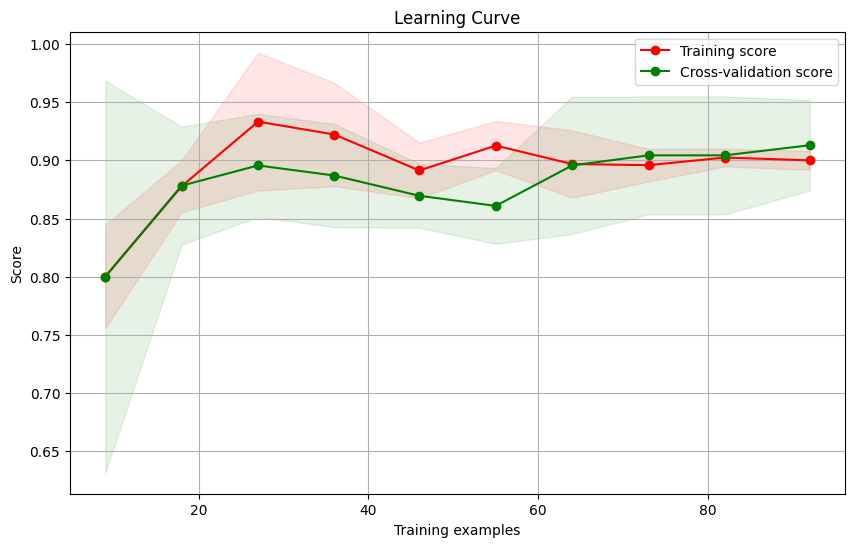

In [11]:
from sklearn.model_selection import learning_curve

# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_knn_classifier, X_train_pca, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()


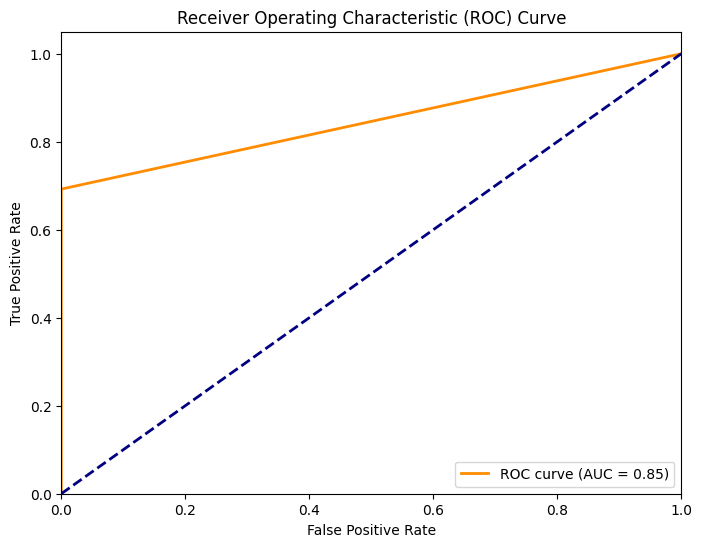

AUC (Area Under the Curve): 0.85


In [12]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Calculate ROC curve for testing data
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Calculate AUC for testing data
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display AUC value
print("AUC (Area Under the Curve): {:.2f}".format(roc_auc))
